In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 2s 0us/step


# The dataset
We will use a dataset containing about 3700 images of different flowers. The folder structure of the dataset is as follows:

* flower_photo/
  - daisy/
  - dandelion/
  - roses/
  - sunflowers/
  - tulips/

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


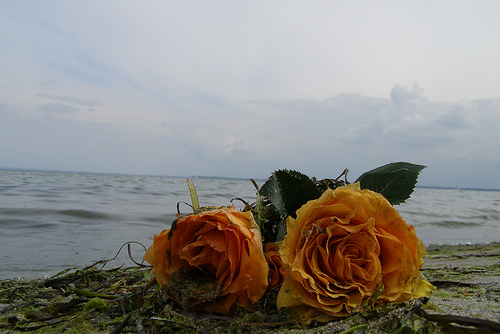

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[10]))

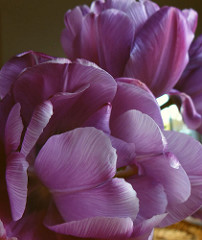

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

## Create a tensorflow dataset

In [8]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    subset = 'training',
    seed = 123,
    validation_split = 0.2,
    image_size = (img_height, img_width),
    batch_size = batch_size
)



Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split = 0.2,
  subset = "validation",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [10]:
class_names = train_ds.class_names
print(f'The names of the found classes: {class_names}')

The names of the found classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# Visualize the data


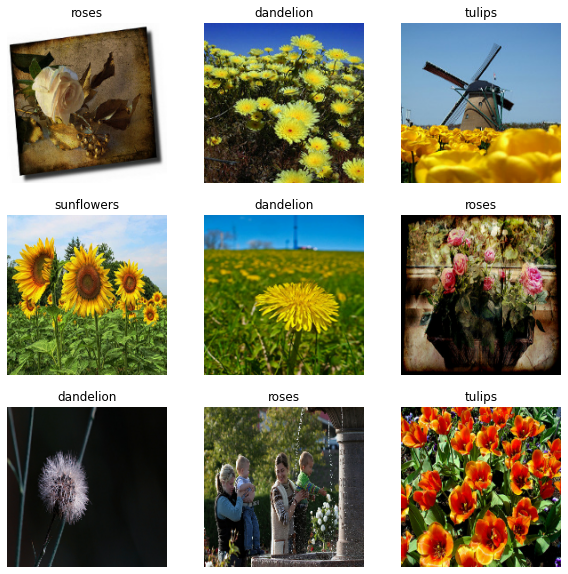

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


This means that we have 32 images in each batch, each image of size 180 x 180 with the 3 corresponding to the RGB channels. 

# Configure the dataset for performance

We will use:
* `Dataset.cache()`to keep images in memory after they're loaded form disk during the first epoch.
* `Dataset.prefetch()` overlaps data preprocessing and and model execution while training. 

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

# Standardize the data
We will use a rescaling layer to make sure that the RGB values are in the range 0 to 1 instead of 0 to 255. 

We can eather preprocess the data by running each image through a normalization layer:

In [14]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1.0 / 255.0)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Note that the pixel values are in the range 0-1
print(np.min(first_image), np.max(first_image))

0.005936881 0.9981924


We mayt also choose to include the normalization layer inside the model. We will work with this approach!

## Create the model

In [15]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1.0/255.0, input_shape = (img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding = 'same', activation ='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation = 'relu'),
  layers.Dense(num_classes)
])

In [16]:
# Compile the model

model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

# Train the model

In [17]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/10
92/92 [==============================] - 36s 41ms/step - loss: 1.5942 - accuracy: 0.3001 - val_loss: 1.1155 - val_accuracy: 0.5341
Epoch 2/10
92/92 [==============================] - 2s 20ms/step - loss: 1.0493 - accuracy: 0.5792 - val_loss: 1.0249 - val_accuracy: 0.5804
Epoch 3/10
92/92 [==============================] - 2s 20ms/step - loss: 0.9018 - accuracy: 0.6441 - val_loss: 0.9965 - val_accuracy: 0.5940
Epoch 4/10
92/92 [==============================] - 2s 20ms/step - loss: 0.7267 - accuracy: 0.7228 - val_loss: 0.9220 - val_accuracy: 0.6431
Epoch 5/10
92/92 [==============================] - 2s 20ms/step - loss: 0.5209 - accuracy: 0.8073 - val_loss: 0.9053 - val_accuracy: 0.6526
Epoch 6/10
92/92 [==============================] - 2s 20ms/step - loss: 0.2721 - accuracy: 0.9036 - val_loss: 1.0263 - val_accuracy: 0.6403
Epoch 7/10
92/92 [==============================] - 2s 20ms/step - loss: 0.1501 - accuracy: 0.9613 - val_loss: 1.1888 - val_accuracy: 0.6294
Epoch 8/10
9

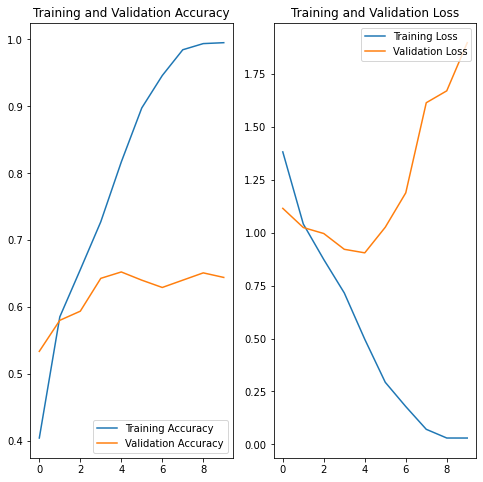

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Overfitting

As we can see, the validation performance does not follow the training performance. This indicates that we are overfitting our model. Overfitting generally occures when we have a too small dataset to train on.

### Data augmentation

One solution to overfitting can be to augment the data. This way, we can create more training examples by applying random transformations on the existing images that yield realistic looking results. 

In [19]:
data_augmentation = Sequential([
                                layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                                             input_shape = (img_width,
                                                                                            img_height,
                                                                                            3)),
                                layers.experimental.preprocessing.RandomRotation(0.1),
                                layers.experimental.preprocessing.RandomZoom(0.1)
]
)



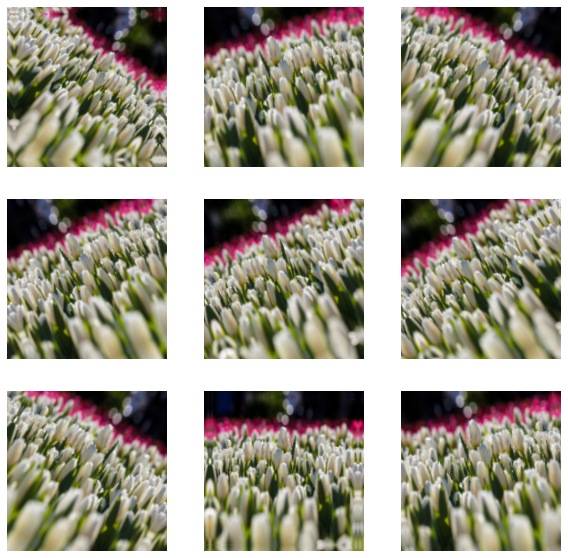

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [21]:
# We can also use a regularization technique known as
# dropout to reduce overfitting. A dropout layer sets
# some of the activations to 0.

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [22]:
# Lets compile again
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [23]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 3s 25ms/step - loss: 1.3942 - accuracy: 0.3650 - val_loss: 1.1691 - val_accuracy: 0.5245
Epoch 2/15
92/92 [==============================] - 2s 22ms/step - loss: 0.9922 - accuracy: 0.6159 - val_loss: 0.9656 - val_accuracy: 0.6049
Epoch 3/15
92/92 [==============================] - 2s 22ms/step - loss: 0.8997 - accuracy: 0.6670 - val_loss: 0.9186 - val_accuracy: 0.6485
Epoch 4/15
92/92 [==============================] - 2s 22ms/step - loss: 0.8238 - accuracy: 0.6810 - val_loss: 0.8424 - val_accuracy: 0.6431
Epoch 5/15
92/92 [==============================] - 2s 22ms/step - loss: 0.7630 - accuracy: 0.7197 - val_loss: 0.8012 - val_accuracy: 0.6812
Epoch 6/15
92/92 [==============================] - 2s 22ms/step - loss: 0.7544 - accuracy: 0.7143 - val_loss: 0.7627 - val_accuracy: 0.6826
Epoch 7/15
92/92 [==============================] - 2s 22ms/step - loss: 0.7152 - accuracy: 0.7276 - val_loss: 0.8262 - val_accuracy: 0.6798
Epoch 8/15
92

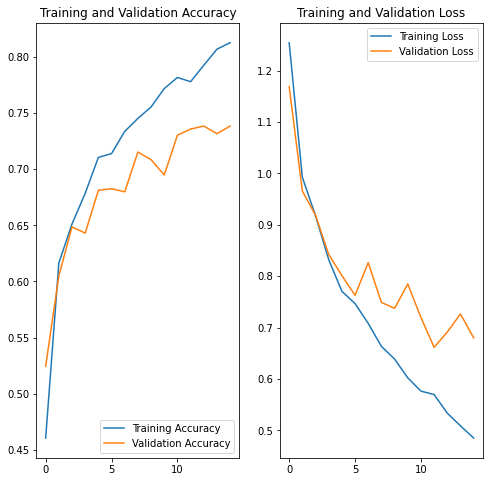

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
## Lets try our model on some new data

sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflowers with a 98.70 percent confidence.
